In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"

from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [2]:
train = pd.read_csv('C:/Users/dkswl/K-digital ML/food demand forecasting/train.csv')
test = pd.read_csv('C:/Users/dkswl/K-digital ML/food demand forecasting/test.csv')
meal = pd.read_csv('C:/Users/dkswl/K-digital ML/food demand forecasting/meal_info.csv')
center_info = pd.read_csv('C:/Users/dkswl/K-digital ML/food demand forecasting/fulfilment_center_info.csv')
sub= pd.read_csv('C:/Users/dkswl/K-digital ML/food demand forecasting/sample_submission.csv')

## Train dataset 생성

In [3]:
train_join = train.merge(meal, on="meal_id", how="inner")
train_full = train_join.merge(center_info, on="center_id", how="inner")

In [4]:
train_full.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine,city_code,region_code,center_type,op_area
0,1379560,1,55,1885,136.83,152.29,0,0,177,Beverages,Thai,647,56,TYPE_C,2.0
1,1018704,2,55,1885,135.83,152.29,0,0,323,Beverages,Thai,647,56,TYPE_C,2.0
2,1196273,3,55,1885,132.92,133.92,0,0,96,Beverages,Thai,647,56,TYPE_C,2.0
3,1116527,4,55,1885,135.86,134.86,0,0,163,Beverages,Thai,647,56,TYPE_C,2.0
4,1343872,5,55,1885,146.50,147.50,0,0,215,Beverages,Thai,647,56,TYPE_C,2.0


In [5]:
nCar = train_full.shape[0] #전체의 행 갯수 반환
nVar = train_full.shape[1] #전체의 열 갯수 반환
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 456548 nVar: 15


## [Train] 데이터 전처리 : 범주형 변수 >> 연속형 변수 (LabelEncoding)

In [6]:
# category

train_full['category'].unique()

array(['Beverages', 'Rice Bowl', 'Starters', 'Pasta', 'Sandwich',
       'Biryani', 'Extras', 'Pizza', 'Seafood', 'Other Snacks', 'Desert',
       'Salad', 'Fish', 'Soup'], dtype=object)

In [7]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_full['category'] = le.fit_transform(train_full['category'])

In [8]:
# 체킹용
# train_full.head()

In [9]:
train_full['category'].unique()

array([ 0,  8, 13,  6, 10,  1,  3,  7, 11,  5,  2,  9,  4, 12])

In [10]:
#cuisine

train_full['cuisine'].unique()

array(['Thai', 'Indian', 'Italian', 'Continental'], dtype=object)

In [11]:
le = LabelEncoder()
train_full['cuisine'] = le.fit_transform(train_full['cuisine'])

In [12]:
train_full['cuisine'].unique()

array([3, 1, 2, 0])

In [13]:
# train_full.head()

In [14]:
#center_type

train_full['center_type'].unique()

array(['TYPE_C', 'TYPE_B', 'TYPE_A'], dtype=object)

In [15]:
le = LabelEncoder()
train_full['center_type'] = le.fit_transform(train_full['center_type'])

In [16]:
train_full.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine,city_code,region_code,center_type,op_area
0,1379560,1,55,1885,136.83,152.29,0,0,177,0,3,647,56,2,2.0
1,1018704,2,55,1885,135.83,152.29,0,0,323,0,3,647,56,2,2.0
2,1196273,3,55,1885,132.92,133.92,0,0,96,0,3,647,56,2,2.0
3,1116527,4,55,1885,135.86,134.86,0,0,163,0,3,647,56,2,2.0
4,1343872,5,55,1885,146.50,147.50,0,0,215,0,3,647,56,2,2.0


## Train 데이터로 변수선택법

In [17]:
import statsmodels.api as sm

In [18]:
# 설명변수(X), 타겟변수(Y) 분리 및 학습데이터와 평가데이터 분할

train_full.columns.difference({'num_orders'}) #특정 변수 제외

Index(['base_price', 'category', 'center_id', 'center_type', 'checkout_price',
       'city_code', 'cuisine', 'emailer_for_promotion', 'homepage_featured',
       'id', 'meal_id', 'op_area', 'region_code', 'week'],
      dtype='object')

In [19]:
## 전진 선택법
variables = train_full.columns[:-2].tolist() ## 설명 변수 리스트
 
y = train_full['num_orders'] ## 반응 변수
selected_variables = [] ## 선택된 변수들
sl_enter = 0.05
 
sv_per_step = [] ## 각 스텝별로 선택된 변수들
adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
steps = [] ## 스텝
step = 0
while len(variables) > 0:
    remainder = list(set(variables) - set(selected_variables))
    pval = pd.Series(index=remainder) ## 변수의 p-value
    ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 
    ## 선형 모형을 적합한다.
    for col in remainder: 
        X = train_full[selected_variables+[col]]
        X = sm.add_constant(X)
        model = sm.OLS(y,X).fit()
        pval[col] = model.pvalues[col]
 
    min_pval = pval.min()
    if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
        selected_variables.append(pval.idxmin())
        
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(y,sm.add_constant(train_full[selected_variables])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
    else:
        break

In [20]:
selected_variables

['num_orders', 'id']

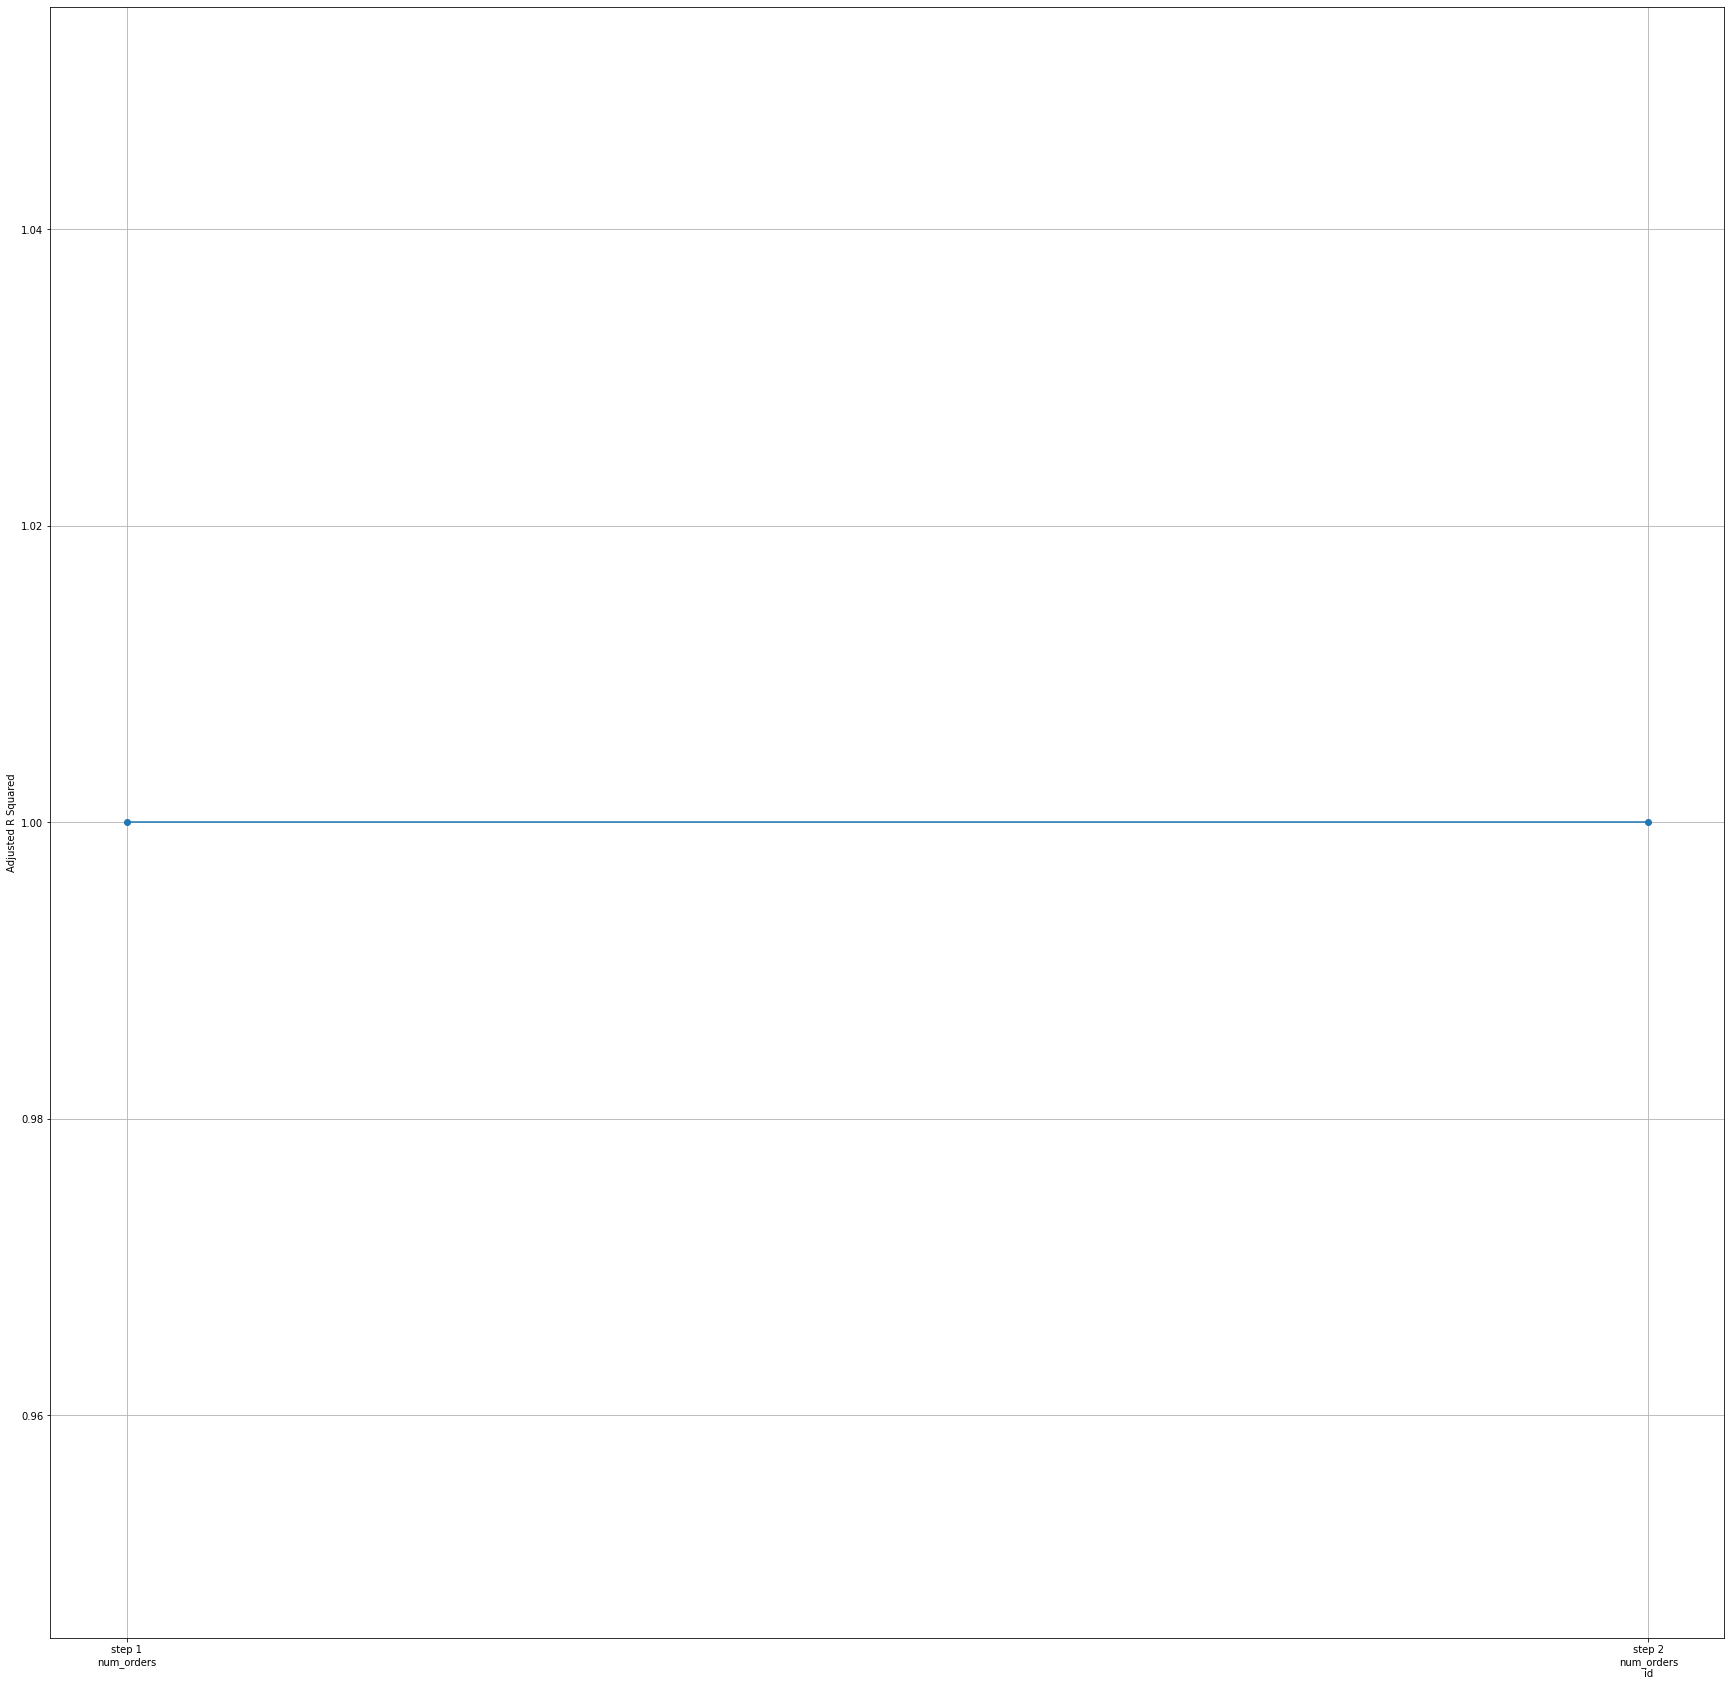

In [21]:
fig = plt.figure(figsize=(30,30))
fig.set_facecolor('white')
 
font_size = 10
plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=10)
plt.plot(steps,adjusted_r_squared, marker='o')
    
plt.ylabel('Adjusted R Squared',fontsize=font_size)
plt.grid(True)
plt.show()

In [22]:
## 후진 소거법
variables = train_full.columns[:-2].tolist() ## 설명 변수 리스트
 
y = train_full['num_orders'] ## 반응 변수
selected_variables = variables ## 초기에는 모든 변수가 선택된 상태
sl_remove = 0.05
 
sv_per_step = [] ## 각 스텝별로 선택된 변수들
adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
steps = [] ## 스텝
step = 0
while len(selected_variables) > 0:
    X = sm.add_constant(train_full[selected_variables])
    p_vals = sm.OLS(y,X).fit().pvalues[1:] ## 절편항의 p-value는 뺀다
    max_pval = p_vals.max() ## 최대 p-value
    if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
        remove_variable = p_vals.idxmax()
        selected_variables.remove(remove_variable)
 
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(y,sm.add_constant(train_full[selected_variables])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
    else:
        break

In [23]:
selected_variables

['id',
 'week',
 'center_id',
 'checkout_price',
 'base_price',
 'emailer_for_promotion',
 'homepage_featured',
 'num_orders',
 'category',
 'region_code']

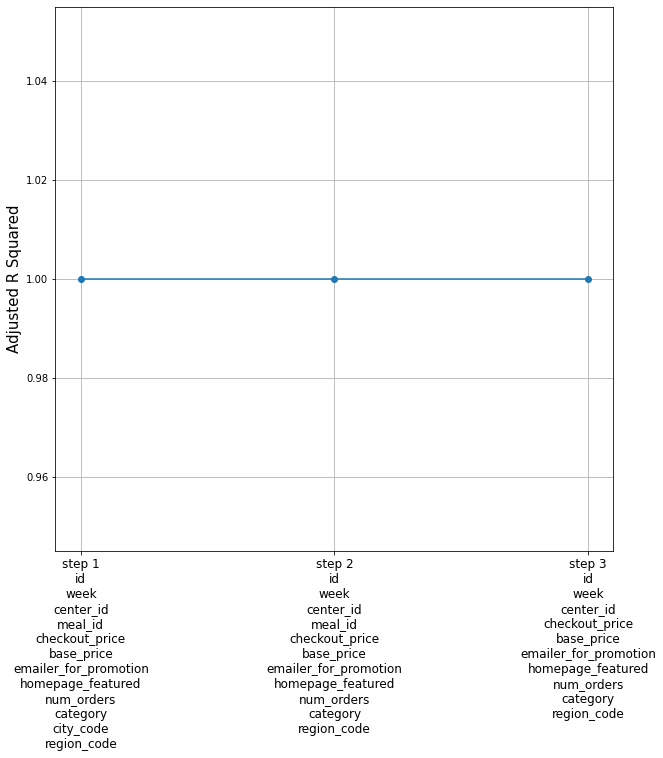

In [24]:
fig = plt.figure(figsize=(10,10))
fig.set_facecolor('white')
 
font_size = 15
plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12)
plt.plot(steps,adjusted_r_squared, marker='o')
    
plt.ylabel('Adjusted R Squared',fontsize=font_size)
plt.grid(True)
plt.show()

## Train data 적합한 변수 제외하고 정리

- 최종 내가 선택한 변수: 'id', 'week', 'center_id', 'meal_id', 'checkout_price', 'base_price', 'emailer_for_promotion', 'homepage_featured', 'category', 'cuisine', 'region_code'
- 타겟: 'num_orders'

In [25]:
train_full.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine,city_code,region_code,center_type,op_area
0,1379560,1,55,1885,136.83,152.29,0,0,177,0,3,647,56,2,2.0
1,1018704,2,55,1885,135.83,152.29,0,0,323,0,3,647,56,2,2.0
2,1196273,3,55,1885,132.92,133.92,0,0,96,0,3,647,56,2,2.0
3,1116527,4,55,1885,135.86,134.86,0,0,163,0,3,647,56,2,2.0
4,1343872,5,55,1885,146.50,147.50,0,0,215,0,3,647,56,2,2.0


In [26]:
train_final = train_full.drop(['city_code', 'center_type', 'op_area'], axis = 'columns')

In [27]:
#그저 내가 쉽게 보려고 재배치 (타겟변수 맨 뒤로 옮기기)
train_final=train_final[['id', 'week', 'center_id', 'meal_id', 'checkout_price', 'base_price', 'emailer_for_promotion',
                         'homepage_featured', 'category', 'cuisine', 'region_code', 'num_orders']]

In [28]:
train_final.head(5)

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,category,cuisine,region_code,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,0,3,56,177
1,1018704,2,55,1885,135.83,152.29,0,0,0,3,56,323
2,1196273,3,55,1885,132.92,133.92,0,0,0,3,56,96
3,1116527,4,55,1885,135.86,134.86,0,0,0,3,56,163
4,1343872,5,55,1885,146.50,147.50,0,0,0,3,56,215


## test data 전처리 및 적합한 변수 제외하고 정리

In [29]:
test_join = test.merge(meal, on="meal_id", how="inner")
test_full = test_join.merge(center_info, on="center_id", how="inner")

In [30]:
test_full.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,category,cuisine,city_code,region_code,center_type,op_area
0,1028232,146,55,1885,158.11,159.11,0,0,Beverages,Thai,647,56,TYPE_C,2.0
1,1262649,147,55,1885,159.11,159.11,0,0,Beverages,Thai,647,56,TYPE_C,2.0
2,1453211,149,55,1885,157.14,158.14,0,0,Beverages,Thai,647,56,TYPE_C,2.0
3,1262599,150,55,1885,159.14,157.14,0,0,Beverages,Thai,647,56,TYPE_C,2.0
4,1495848,151,55,1885,160.11,159.11,0,0,Beverages,Thai,647,56,TYPE_C,2.0


In [31]:
test_full['category'] = le.fit_transform(test_full['category'])
test_full['cuisine'] = le.fit_transform(test_full['cuisine'])
test_full['center_type'] = le.fit_transform(test_full['center_type'])

In [32]:
test_final = test_full.drop(['city_code', 'center_type', 'op_area'], axis = 'columns')

In [33]:
test_final.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,category,cuisine,region_code
0,1028232,146,55,1885,158.11,159.11,0,0,0,3,56
1,1262649,147,55,1885,159.11,159.11,0,0,0,3,56
2,1453211,149,55,1885,157.14,158.14,0,0,0,3,56
3,1262599,150,55,1885,159.14,157.14,0,0,0,3,56
4,1495848,151,55,1885,160.11,159.11,0,0,0,3,56


## XGBoost

### 학습, 테스트 데이터 준비

In [34]:
feature_columns = list(train_final.columns.difference(['num_orders']))
x_train = train_final[feature_columns]

In [35]:
x_train

,base_price,category,center_id,checkout_price,cuisine,emailer_for_promotion,homepage_featured,id,meal_id,region_code,week
0,152.29,0,55,136.83,3,0,0,1379560,1885,56,1
1,152.29,0,55,135.83,3,0,0,1018704,1885,56,2
2,133.92,0,55,132.92,3,0,0,1196273,1885,56,3
3,134.86,0,55,135.86,3,0,0,1116527,1885,56,4
4,147.50,0,55,146.50,3,0,0,1343872,1885,56,5
...,...,...,...,...,...,...,...,...,...,...,...
456543,630.53,4,61,583.03,0,0,1,1437396,2104,77,141
456544,582.03,4,61,581.03,0,0,0,1060716,2104,77,142
456545,581.03,4,61,583.03,0,0,0,1029231,2104,77,143
456546,581.03,4,61,582.03,0,0,0,1141147,2104,77,144


In [36]:
y_train = train_final['num_orders']

In [38]:
y_train.head()

0    177
1    323
2     96
3    163
4    215
Name: num_orders, dtype: int64

In [39]:
feature_columns = list(test_final.columns.difference(['num_orders']))
x_test = test_final[feature_columns]

In [43]:
# !pip install xgboost
from xgboost import XGBRegressor

model = XGBRegressor(n_estimators = 100)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
result = pd.DataFrame({'num_orders' : y_pred})

result.head()

,num_orders
0,629.580444
1,612.911743
2,615.577820
3,612.911743
4,575.780518


In [58]:
result

,num_orders
0,629.580444
1,612.911743
2,615.577820
3,612.911743
4,575.780518
...,...
32568,25.949244
32569,70.559654
32570,1.502180
32571,1.502180


In [65]:
result = round(result['num_orders']) #반올림

In [93]:
result

0        630.0
1        613.0
2        616.0
3        613.0
4        576.0
         ...  
32568     26.0
32569     71.0
32570      2.0
32571      2.0
32572      2.0
Name: num_orders, Length: 32573, dtype: float32

In [96]:
final_predict = pd.DataFrame({'id': sub['id'], 'num_orders': result})
final_predict.head()

,id,num_orders
0,1028232,630.0
1,1127204,613.0
2,1212707,616.0
3,1082698,613.0
4,1400926,576.0


In [99]:
final_predict.to_csv('sample_submission.csv')